In [2]:
!pip install bayesian-optimization

In [18]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

import yfinance as yf

import matplotlib.pyplot as plt

In [4]:
Tickers = ['JPM', 'BAC', 'WFC', 'C', 'BLK', 'GS', 'MS', 'SCHW', 'AXP', 'USB', 'TFC', 'PNC', 'BK', 'COF', 'STT', 'FITB']

data = yf.download(Tickers, start="2013-01-01", end="2018-01-01")
df = data["Adj Close"].dropna(how="all")

df.tail()

/tmp/ipython-input-4-3069331130.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(Tickers, start="2013-01-01", end="2018-01-01")
[*********************100%***********************]  16 of 16 completed


Ticker,AXP,BAC,BK,BLK,C,COF,FITB,GS,JPM,MS,PNC,SCHW,STT,TFC,USB,WFC
Date,,,,,,,,,,,,,,,,
2017-12-22,89.037552,25.027311,43.744736,423.272278,58.465050,88.082527,23.335083,219.275085,87.166267,42.024368,112.741394,46.994865,77.852333,36.714962,40.767914,49.810497
2017-12-26,88.884262,24.943550,43.590816,424.594666,57.915176,87.574196,23.214014,218.216644,86.817436,41.825089,111.800095,46.805359,77.462852,36.416595,40.431038,49.470608
2017-12-27,89.389221,24.901672,43.615124,425.090607,58.000385,87.425224,23.198881,216.717926,86.979691,41.904804,111.861816,46.787323,77.677452,36.372921,40.475967,49.324944
2017-12-28,89.903214,24.960300,43.841942,428.115601,58.147537,87.907257,23.305367,217.183685,87.442101,41.968578,112.394188,46.958767,78.090851,36.474804,40.611462,49.608181
2017-12-29,89.551544,24.725779,43.631325,424.586487,57.628643,87.276199,23.077183,215.710388,86.752541,41.825089,111.329422,46.354179,77.931168,36.183701,40.332939,49.098358


In [5]:
def cointegration_checker(stock_dataframe):
    cointegrated_pairs = []

    k = stock_dataframe.shape[1]
    #getting the number of columns (tickers)
    p_values = np.ones( (k, k) )


    keys = stock_dataframe.keys()
    #getting the column names (tickers) from df

    for i in range(k):
        for j in range(i+1, k):

            Asset_1 = stock_dataframe[keys[i]]
            Asset_2 = stock_dataframe[keys[j]]

            #iterating through the df and testing cointegration for all pairs of tickers
            Coint_Test = coint(Asset_1, Asset_2)

            pvalue = Coint_Test[1]
            # statsmodels coint returns p-values (our primary concern) in the 1th index slot
            p_values[i, j] = pvalue
            #p value matrix where the output of the coint test is the ith, jth index
            if pvalue < 0.02:
                cointegrated_pairs.append((keys[i], keys[j]))

    return p_values, cointegrated_pairs

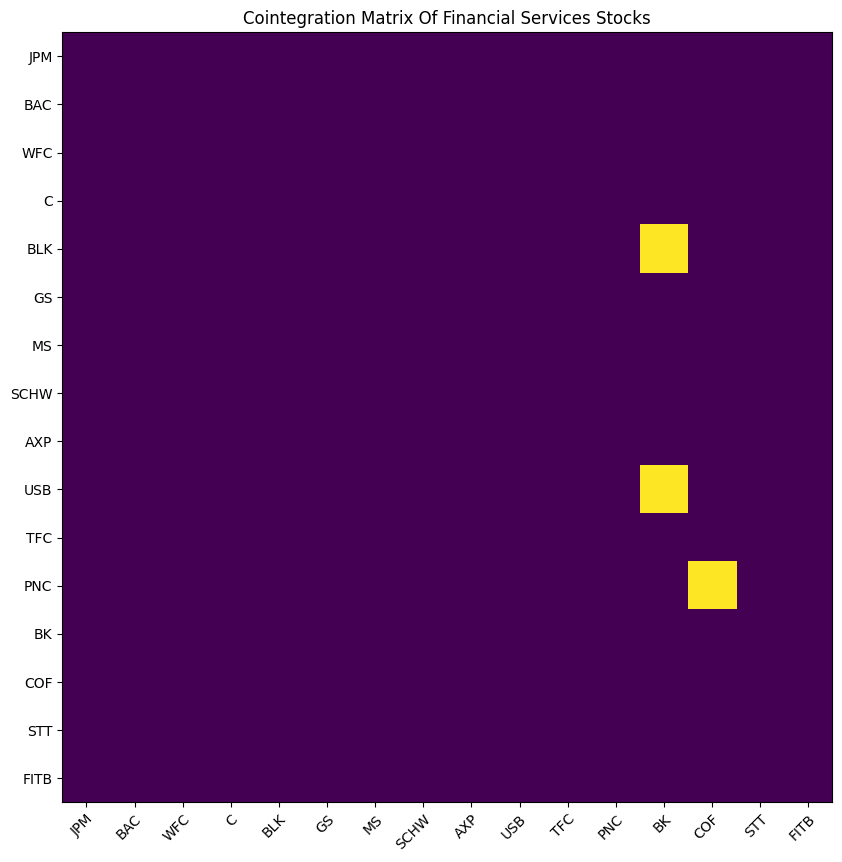

[('C', 'STT'), ('MS', 'STT'), ('SCHW', 'TFC')]


In [6]:
pvalues, pairs = cointegration_checker(df)
fig, ax = plt.subplots(figsize=(25, 10))
im = ax.imshow(pvalues <= .02)

ax.set_xticks(np.arange(len(Tickers)))
ax.set_yticks(np.arange(len(Tickers)))

ax.set_xticklabels(Tickers)
ax.set_yticklabels(Tickers)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Cointegration Matrix Of Financial Services Stocks")
plt.show()
print(pairs)

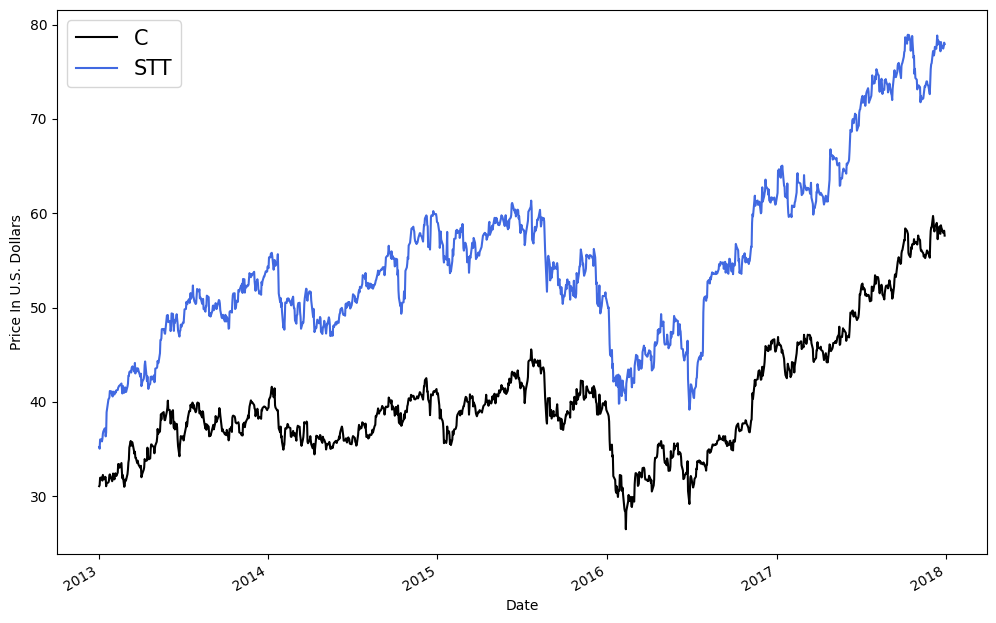

In [7]:
plt.figure(figsize=(12,8))
best = pairs[0]
df[best[0]].plot(color = 'black')
df[best[1]].plot(color = 'royalblue')
plt.legend([best[0], best[1]], prop={'size': 15})
plt.ylabel('Price In U.S. Dollars')
plt.show()

In [8]:
placeholder, pvalue, placeholder2 = coint(df['STT'][0:252], df['C'][0:252])
print("The pvalue of the augmented Engle-Granger two-step cointegration test between $C and $STT is", round(pvalue,5))


The pvalue of the augmented Engle-Granger two-step cointegration test between $C and $STT is 0.17249


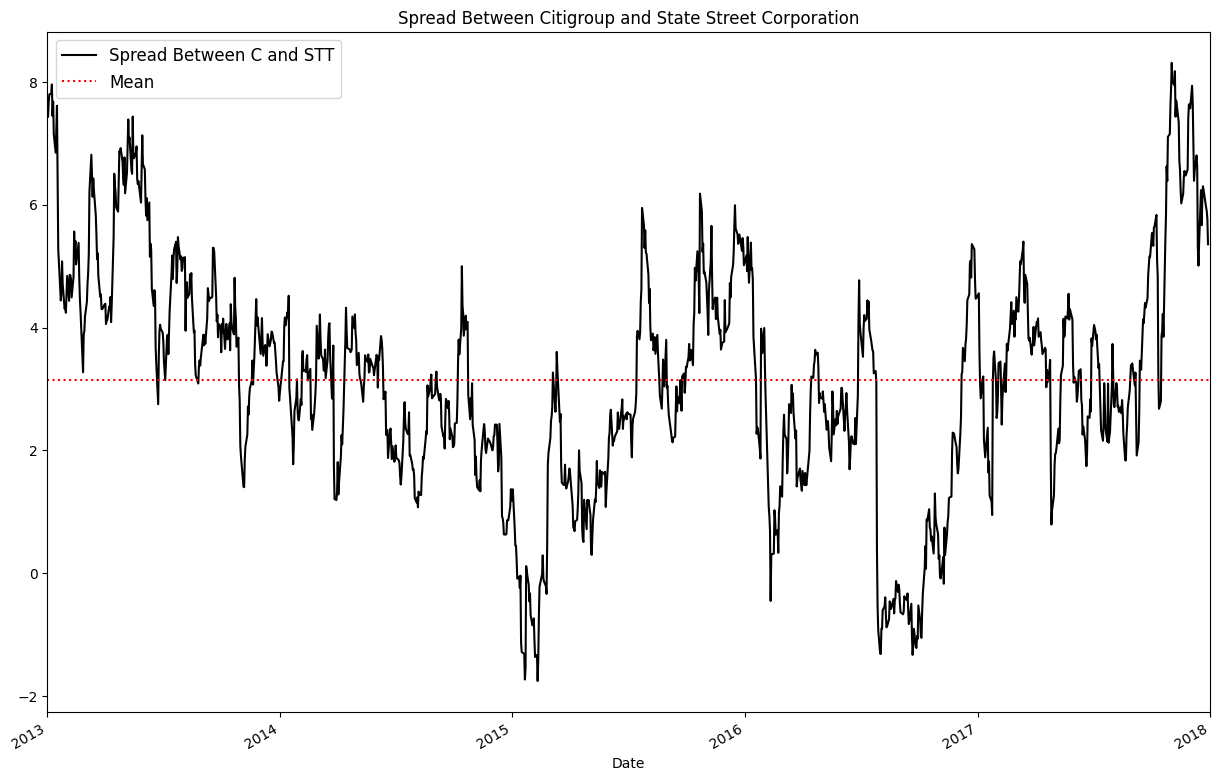

In [9]:
Asset_1 = df[best[1]]
Asset_2 =  df[best[0]]

#calculating the spread
Asset_1  = add_constant(Asset_1)
results = OLS(Asset_2, Asset_1).fit()

coef = results.params[best[1]]
Asset_1 = Asset_1[best[1]]

spread = Asset_2 - (coef * Asset_1)

spread.plot(figsize=(15,10), color = 'black')
plt.xlim('2013-01-01', '2018-01-01')
plt.axhline(spread.mean(), color='red', linestyle=':')
plt.legend(['Spread Between C and STT', 'Mean'], prop={'size': 12});
plt.title("Spread Between Citigroup and State Street Corporation")
plt.show()


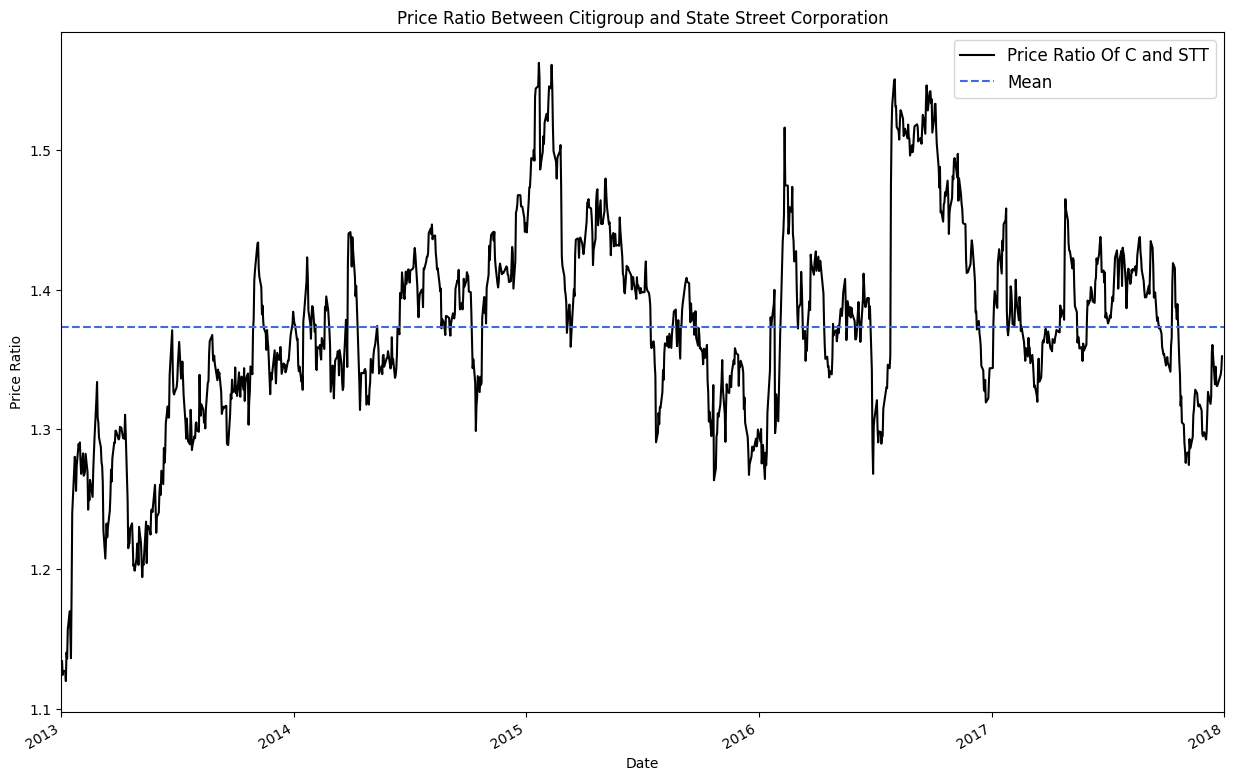

In [10]:
price_ratio = Asset_1/Asset_2
price_ratio.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio.mean(), color='royalblue', linestyle='dashed')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio Of C and STT', 'Mean'], prop={'size': 12});
plt.title("Price Ratio Between Citigroup and State Street Corporation")
plt.ylabel('Price Ratio')
plt.show()

In [11]:
price_ratio_pvalue = round(adfuller(price_ratio)[1],5)
spread_pvalue = round(adfuller(spread)[1],5)

(price_ratio_pvalue, spread_pvalue)

(np.float64(7e-05), np.float64(0.00035))

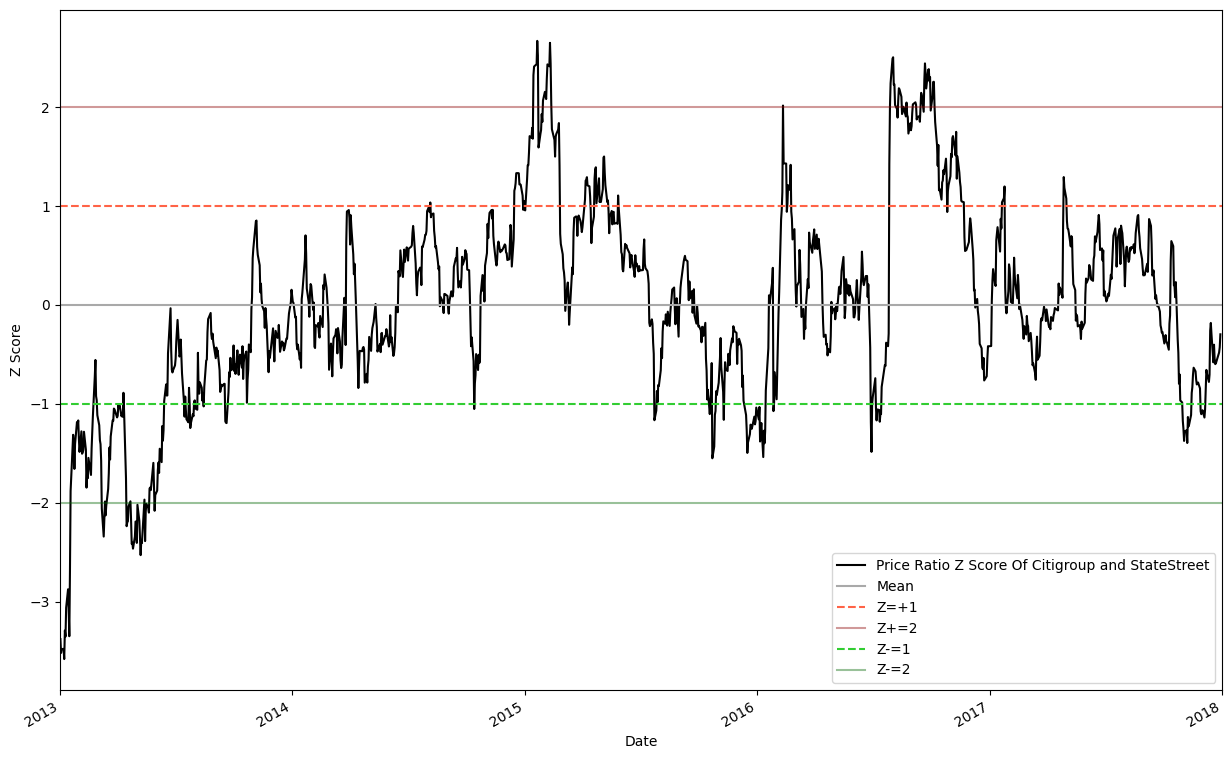

In [12]:
price_ratio_z_score = (price_ratio - price_ratio.mean()) / np.std(price_ratio)
# Z score formula:  (observed value -- mean of the sample) / standard deviation of the sample

price_ratio_z_score.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio_z_score.mean(), color = 'darkgrey' )
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(2, color='darkred', alpha = .4)
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.axhline(-2, color='darkgreen', alpha = .4)


plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio Z Score Of Citigroup and StateStreet', 'Mean', 'Z=+1', 'Z+=2', 'Z-=1', 'Z-=2' ]);
plt.ylabel('Z Score')

plt.show()

In [16]:
Factor_Tickers = ['MTUM', 'QUAL', 'IQLT', 'VTV', 'QQQ', 'SIZE', 'SPY', 'XLK', 'IXN','VNQ','ITB', 'XLF', 'STT', 'C']
Factor_Dictionary = {'SPY': 'Market', 'MTUM': 'Momentum', 'IQLT': 'International Quality', 'QQQ': 'Large Cap',
                     'QUAL': 'Quality', 'SIZE': 'Size (Small / Medium)', 'VTV': 'Value', 'XLK': 'US Technology',
                    'IXN':'Global Technology', 'VNQ': 'US Real Estate', 'ITB': 'US HomeBuilding', 'XLF': 'Financial Services'}
factor_data = yf.download(Factor_Tickers, start="2016-01-01", end="2018-01-01")
factor_df = factor_data["Close"].dropna(how="all")

factor_df.head()

/tmp/ipython-input-16-3050808460.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  factor_data = yf.download(Factor_Tickers, start="2016-01-01", end="2018-01-01")
[*********************100%***********************]  14 of 14 completed


Ticker,C,IQLT,ITB,IXN,MTUM,QQQ,QUAL,SIZE,SPY,STT,VNQ,VTV,XLF,XLK
Date,,,,,,,,,,,,,,
2016-01-04,38.673466,19.411118,24.858545,14.817276,64.182709,102.094971,55.087631,54.224831,171.349335,49.944130,53.944466,63.499275,15.865847,37.873703
2016-01-05,38.469242,20.025843,24.924732,14.773971,64.486572,101.917847,55.234833,54.224831,171.639114,50.020805,54.985424,63.704296,15.926948,37.775154
2016-01-06,37.909531,19.095873,24.347952,14.543538,64.146919,100.938850,54.576756,53.933121,169.474075,48.357033,54.834755,62.797516,15.682546,37.309219
2016-01-07,35.973217,18.780630,23.336212,14.133710,62.716888,97.778107,53.277931,53.006485,165.408157,46.171879,53.766411,61.330860,15.241263,36.207153
2016-01-08,34.891586,18.567839,22.816154,14.016173,62.118053,96.976265,52.671822,52.371582,163.592529,44.968121,53.047333,60.605450,15.003645,35.920437


In [19]:
def beta_calculation(y,x):

    x = x.pct_change().iloc[1:]
    x = x.to_frame()
    x = x.values

    y = y.pct_change().iloc[1:]
    y = y.to_frame()
    y = y.values


    x = sm.add_constant(x)
    model = OLS(y,x).fit()
    x = x[:, 1]

    return model.params[1]

for i in (Factor_Tickers[:-2]):

  factor_ratio = ((beta_calculation(factor_df['C'],factor_df[i])) / (beta_calculation(factor_df['STT'],factor_df[i])))

  print("The exposure of the pair to {} is {}".format(Factor_Dictionary[factor_df[i].name], round(factor_ratio,2)))

The exposure of the pair to Momentum is 1.13
The exposure of the pair to Quality is 1.11
The exposure of the pair to International Quality is 1.07
The exposure of the pair to Value is 1.17
The exposure of the pair to Large Cap is 1.06
The exposure of the pair to Size (Small / Medium) is 1.14
The exposure of the pair to Market is 1.13
The exposure of the pair to US Technology is 1.06
The exposure of the pair to Global Technology is 1.07
The exposure of the pair to US Real Estate is 1.18
The exposure of the pair to US HomeBuilding is 1.16
The exposure of the pair to Financial Services is 1.22


# Strategy for Trading

Moving Averages

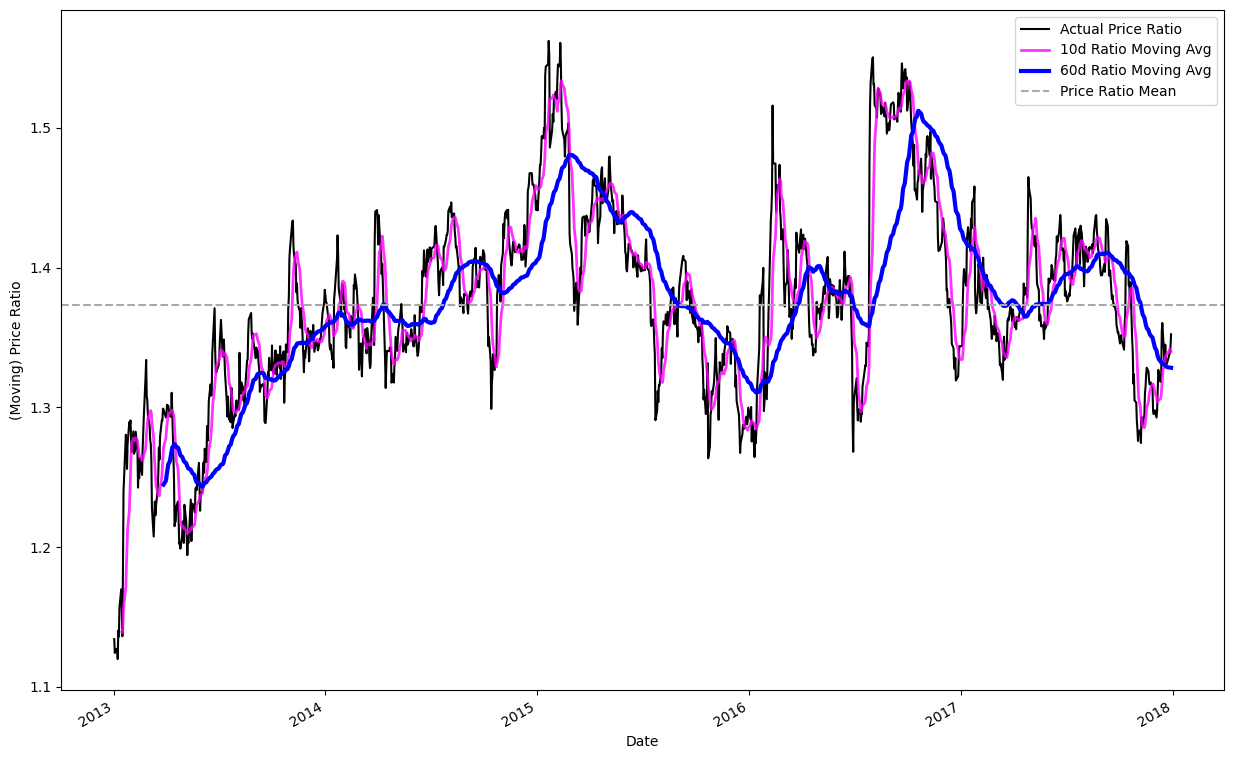

In [20]:
#price ratio = ($STT / $C)
price_ratio = Asset_1/Asset_2

price_ratio_10D_MAVG = price_ratio.rolling(window=10).mean()
price_ratio_60D_MAVG = price_ratio.rolling(window=60).mean()

plt.figure(figsize=(15, 10))
price_ratio.plot(color = 'black')
price_ratio_10D_MAVG.plot(color = 'magenta', linewidth=2, alpha = .8)
price_ratio_60D_MAVG.plot(color = 'b', linewidth=3)
plt.axhline(price_ratio.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Price Ratio', '10d Ratio Moving Avg', '60d Ratio Moving Avg', 'Price Ratio Mean'])
plt.ylabel('(Moving) Price Ratio')
plt.show()

Moving Average of Z-Scores

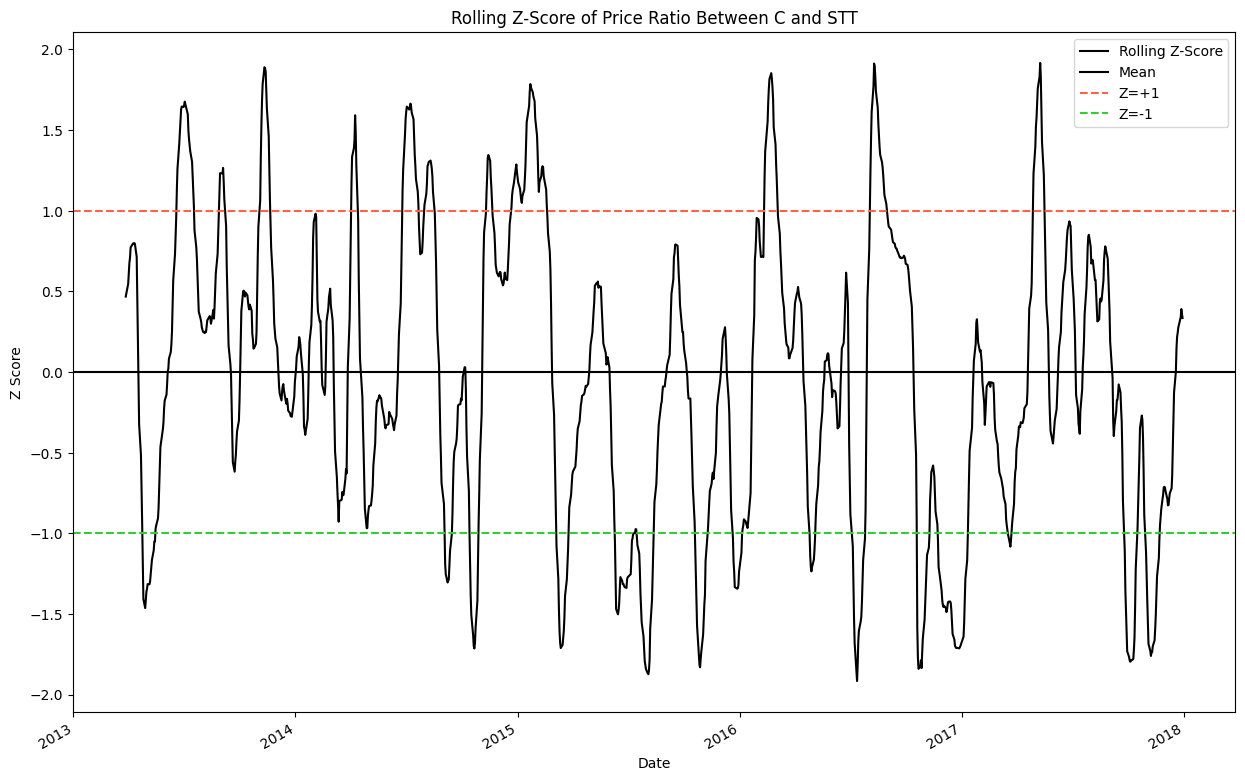

In [21]:
STD_60 = price_ratio.rolling(window=60).std()
Rolling_Z_Score = ((price_ratio_10D_MAVG - price_ratio_60D_MAVG)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

#plt.xlim('2013-01-01', '2018-01-01')
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title("Rolling Z-Score of Price Ratio Between C and STT")
plt.ylabel('Z Score')
plt.show()

Signals

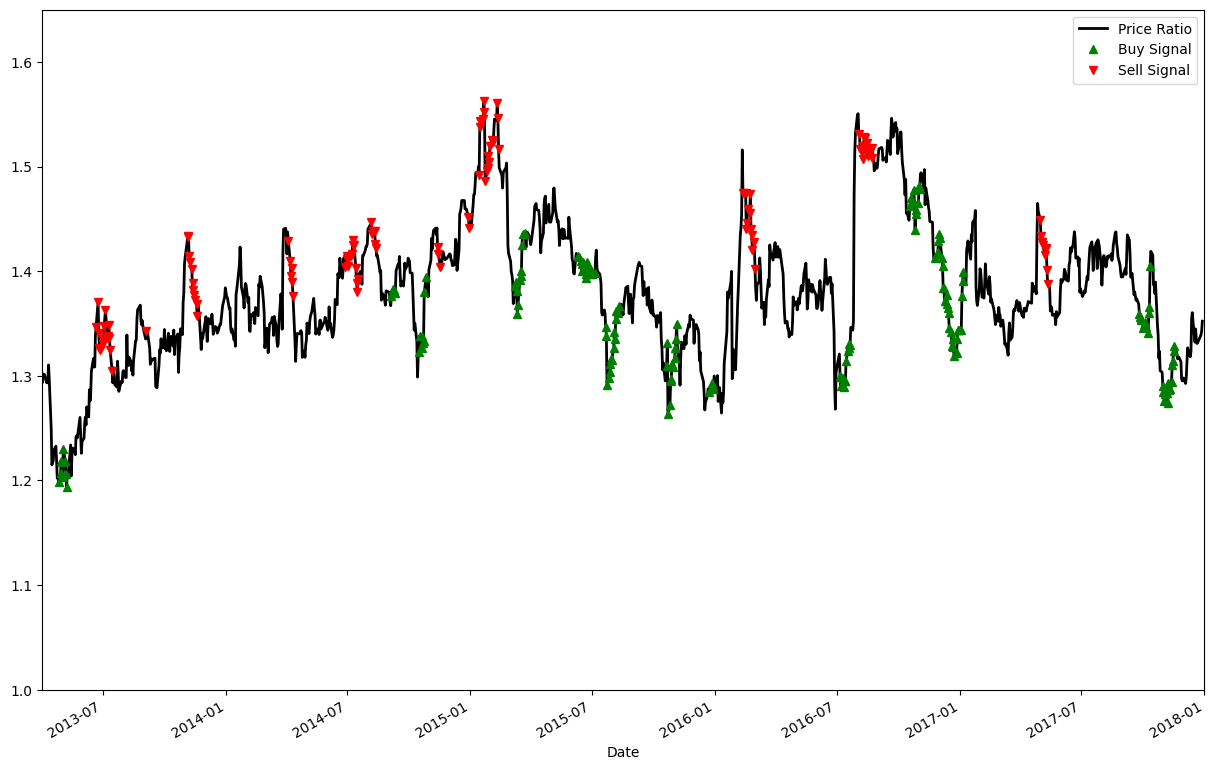

In [22]:
price_ratio.plot(figsize=(15,10), color = 'black', linewidth = 2)
buy  = price_ratio.copy()
sell = price_ratio.copy()


buy[Rolling_Z_Score > -1.25] = 0
buy.plot(color='g', linestyle='None', marker='^')


sell[Rolling_Z_Score < 1.25] = 0
sell.plot(color='r', linestyle='None', marker='v')


plt.axis(('2013-04-01','2018-01-01', 1, 1.65))

plt.legend(['Price Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

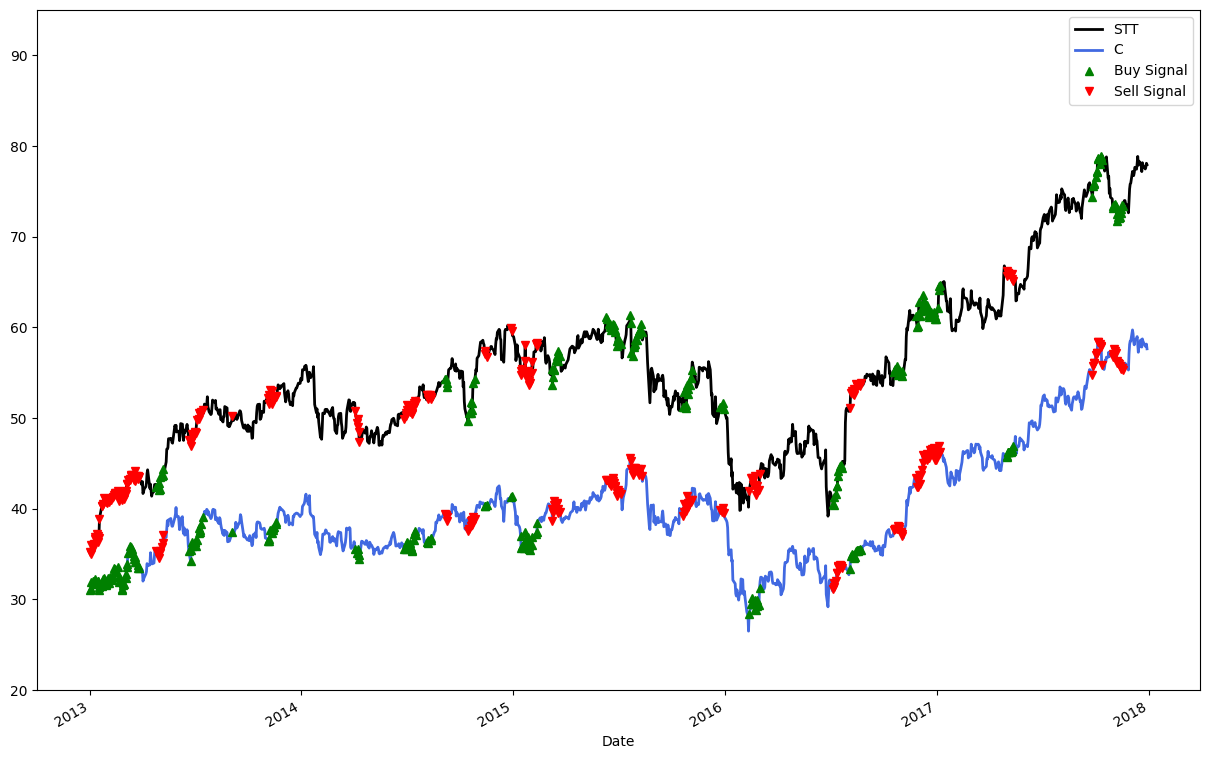

In [23]:
plt.figure(figsize=(15,10))
Asset_1 = df['STT']
Asset_2 = df['C']

Asset_1.plot(color='black', linewidth=2)
Asset_2.plot(color='royalblue', linewidth=2)

Buy_The_Ratio = 0*Asset_1.copy()
Sell_The_Ratio = 0*Asset_1.copy()

# 'buying' the ratio means you buy the higher stock (STT) and sell the lower stock (C)
Buy_The_Ratio[buy!=0] = Asset_1[buy!=0]
Buy_The_Ratio[sell!=0] = Asset_2[sell!=0]

# 'selling' the ratio means you sell the higher stock (STT) and buy the lower stock (C)
Sell_The_Ratio[buy!=0] = Asset_2[buy!=0]
Sell_The_Ratio[sell!=0] = Asset_1[sell!=0]


Buy_The_Ratio.plot(color='g', linestyle='None', marker='^')
Sell_The_Ratio.plot(color='r', linestyle='None', marker='v')

plt.legend(['STT', 'C', 'Buy Signal', 'Sell Signal'])

plt.ylim([20,95])

plt.show()

In [24]:
data_1 = df[best[1]]
data_1

,STT
Date,
2013-01-02,35.224838
2013-01-03,35.035297
2013-01-04,36.004848
2013-01-07,36.041317
2013-01-08,35.800739
...,...
2017-12-22,77.852333
2017-12-26,77.462852
2017-12-27,77.677452


In [25]:
data_2=df[best[0]]
data_2

,C
Date,
2013-01-02,31.057970
2013-01-03,31.163380
2013-01-04,31.946413
2013-01-07,31.976536
2013-01-08,31.969017
...,...
2017-12-22,58.465050
2017-12-26,57.915176
2017-12-27,58.000385


In [30]:
def kalman_filter_pairs(data_1, data_2, Q=0.1, R=0.1):
    n = len(data_1)
    spread = data_1 - data_2
    x_hat = np.zeros(n)    # Predicted state estimate
    P = np.zeros(n)        # Predicted error covariance
    x_hat_minus = np.zeros(n)
    P_minus = np.zeros(n)
    for k in range(1, n):
        # Time update
        x_hat_minus[k] = x_hat[k-1]
        P_minus[k] = P[k-1] + Q
        # Measurement update
        K = P_minus[k] / (P_minus[k] + R)
        x_hat[k] = x_hat_minus[k] + K * (spread.iloc[k] - x_hat_minus[k])
        P[k] = (1 - K) * P_minus[k]
    return x_hat
# Applying Kalman Filter to pairs trading data
filtered_spread = kalman_filter_pairs(data_1, data_2)



In [27]:
def evaluate_params(Q: float, R: float) -> float:

    filt_spread = kalman_filter_pairs(data_1, data_2, Q=Q, R=R)

    # Z-score normalisation (mean-reverting signal)
    z = (filt_spread - np.mean(filt_spread)) / np.std(filt_spread)

    pos = np.where(z < -1,  1,           # long STT / short C
           np.where(z >  1, -1, 0))      # short STT / long C

   # Avoiding Look Ahead Bias
    pos = np.roll(pos, 1)
    pos[0] = 0

    #tick-by-tick PnL of the pair trade
    spread_ret = np.diff(filt_spread, prepend=filt_spread[0])
    pnl        = pos * spread_ret

    # Sharpe ratio (annualised).
    if pnl.std() == 0:
        return 0.0
    sharpe = np.sqrt(252) * pnl.mean() / pnl.std()
    return sharpe


In [28]:
from bayes_opt import BayesianOptimization

bayesian_optimizer = BayesianOptimization(
    f=evaluate_params,
    pbounds={'Q': (0.01, 0.5), 'R': (0.01, 0.5)},
    random_state=42,
    verbose=2
)

bayesian_optimizer.maximize(init_points=5, n_iter=10)

print("Best params :", bayesian_optimizer.max['params'])
print("Best Sharpe :", bayesian_optimizer.max['target'])


|   iter    |  target   |     Q     |     R     |
-------------------------------------------------
| 2         | 1.2728438 | 0.1935246 | 0.4758500 |
| 3         | 1.2219220 | 0.3686770 | 0.3033426 |
| 4         | 1.2262980 | 0.0864491 | 0.0864373 |
| 5         | 1.4960239 | 0.0384609 | 0.4344263 |
| 6         | 1.2409972 | 0.3045463 | 0.3569555 |
| 7         | 1.2727936 | 0.0998682 | 0.0168990 |
| 8         | 1.2219945 | 0.1705509 | 0.4761792 |
| 9         | 1.1960568 | 0.2625425 | 0.3956185 |
| 10        | 1.3129966 | 0.0852824 | 0.3820567 |
| 11        | 1.7357869 | 0.0118122 | 0.4235980 |
| 12        | 1.1995608 | 0.2333762 | 0.3858107 |
| 13        | 1.1999957 | 0.2973753 | 0.4906230 |
| 14        | 1.2791501 | 0.0536538 | 0.2984209 |
| 15        | 1.2049248 | 0.2061057 | 0.1096897 |
| 16        | 1.2223568 | 0.3592939 | 0.2947718 |
Best params : {'Q': np.float64(0.011812248454337567), 'R': np.float64(0.4235980869947157)}
Best Sharpe : 1.7357869730116644


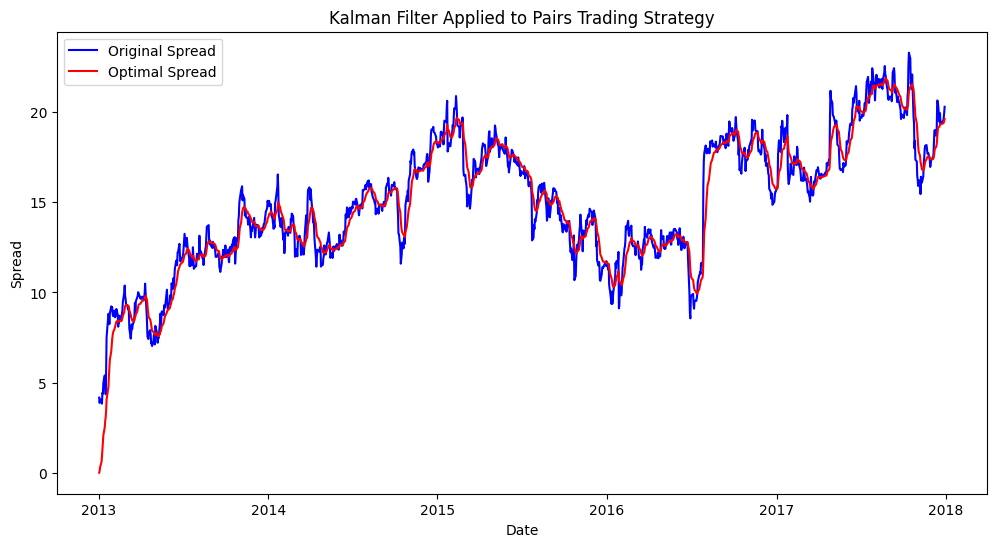

In [32]:
best_params = bayesian_optimizer.max['params']
opt_spread = kalman_filter_pairs(data_1, data_2,
                                 Q=best_params['Q'], R=best_params['R'])
plt.figure(figsize=(12, 6))
plt.plot(data_1.index, data_1.values - data_2.values,
         label='Original Spread', color='b')
plt.plot(data_1.index, opt_spread, label='Optimal Spread', color='r')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.title('Kalman Filter Applied to Pairs Trading Strategy')
plt.show()


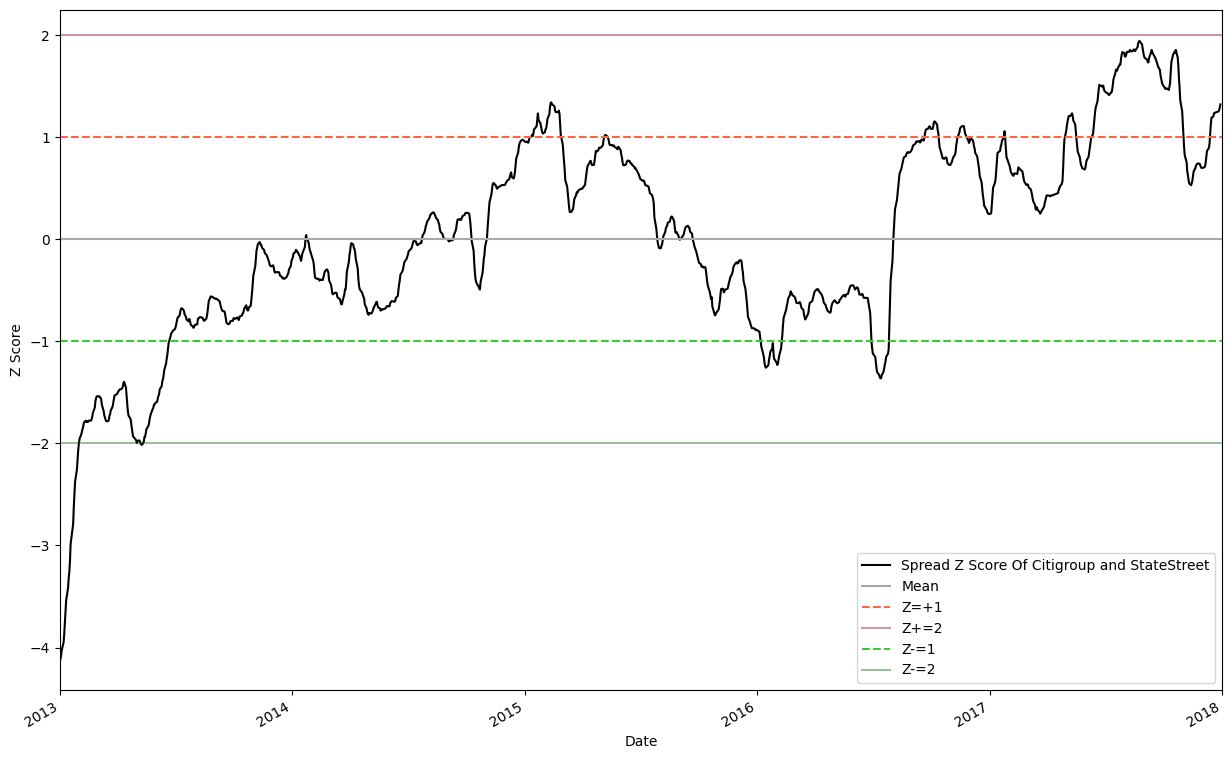

In [39]:
opt_spread = pd.Series(opt_spread, index=data_1.index)

spread_z_score = (opt_spread - opt_spread.mean()) / opt_spread.std()

spread_z_score.plot(figsize=(15,10), color = 'black')
plt.axhline(spread_z_score.mean(), color = 'darkgrey' )
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(2, color='darkred', alpha = .4)
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.axhline(-2, color='darkgreen', alpha = .4)


plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread Z Score Of Citigroup and StateStreet', 'Mean', 'Z=+1', 'Z+=2', 'Z-=1', 'Z-=2' ]);
plt.ylabel('Z Score')

plt.show()

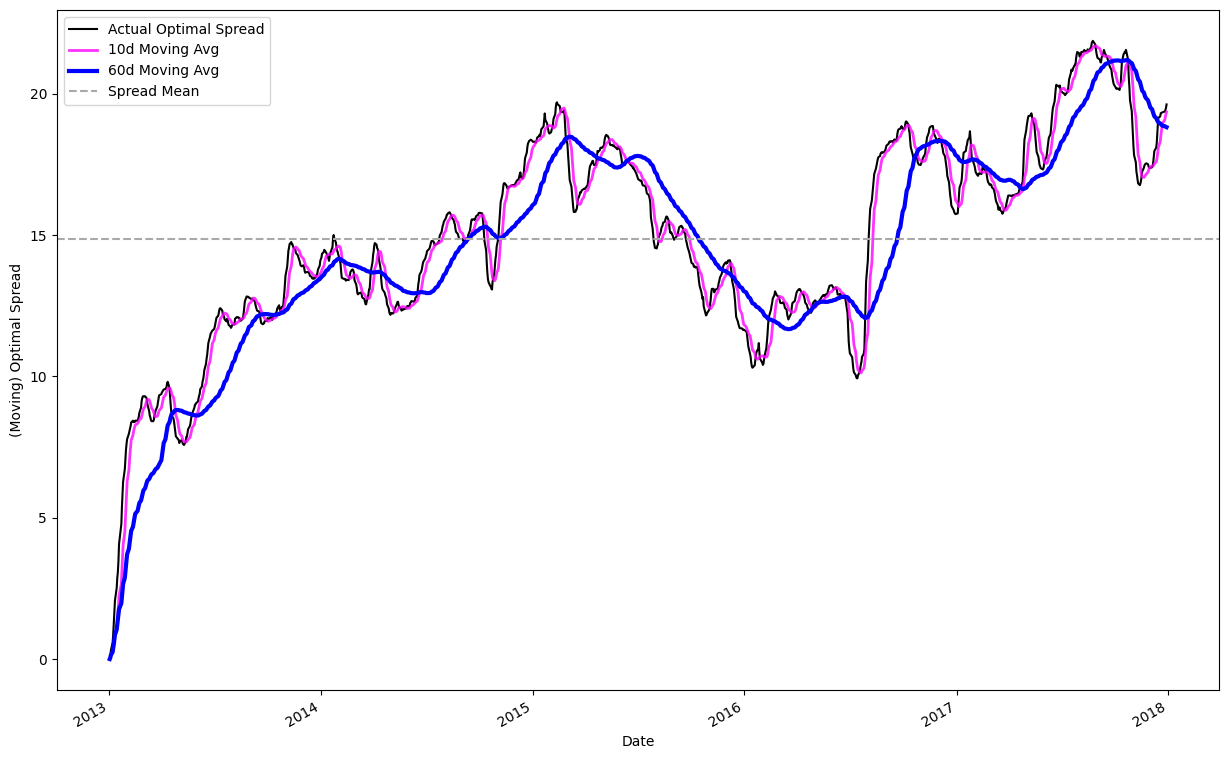

In [45]:

ma_10 = opt_spread.rolling(window=10, min_periods=1).mean()
ma_60 = opt_spread.rolling(window=60, min_periods=1).mean()

plt.figure(figsize=(15, 10))
opt_spread.plot(color = 'black')
ma_10.plot(color = 'magenta', linewidth=2, alpha = .8)
ma_60.plot(color = 'b', linewidth=3)
plt.axhline(opt_spread.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Optimal Spread', '10d Moving Avg', '60d Moving Avg', 'Spread Mean'])
plt.ylabel('(Moving) Optimal Spread')
plt.show()

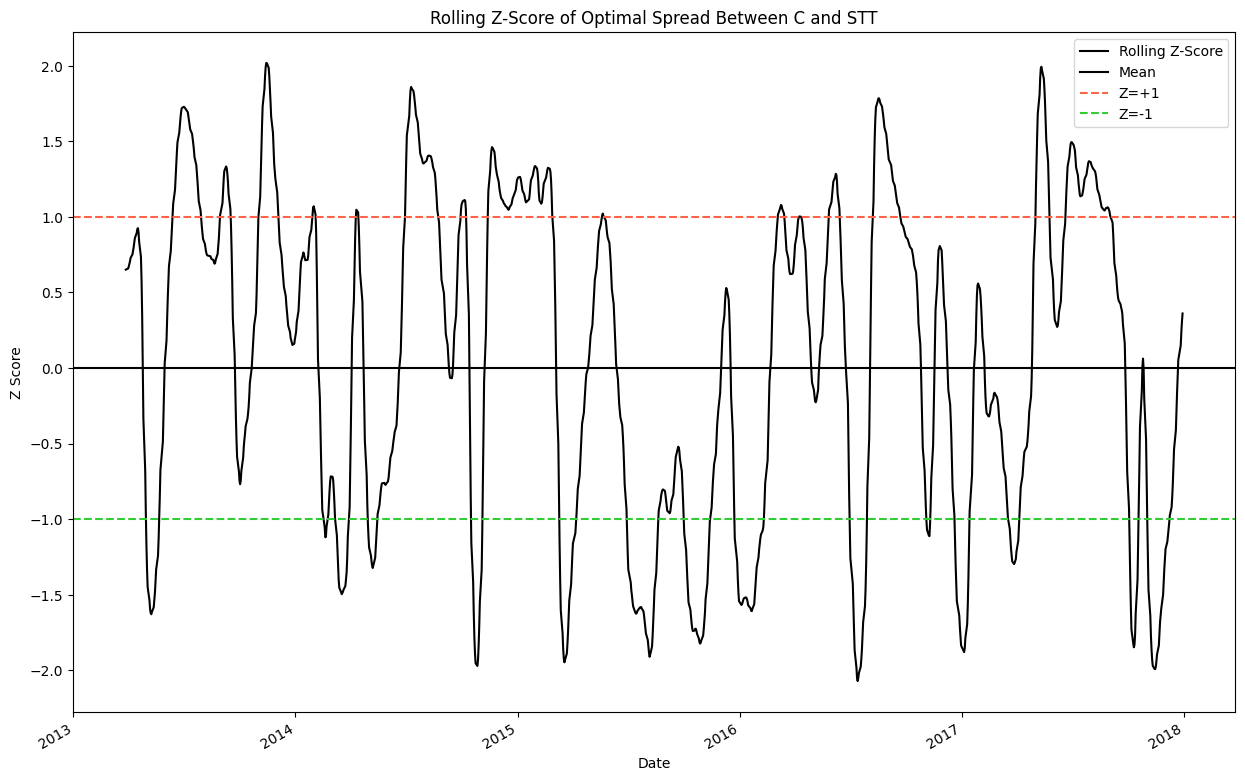

In [47]:
STD_60 = opt_spread.rolling(window=60).std()
Rolling_Z_Score = ((ma_10 - ma_60)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

#plt.xlim('2013-01-01', '2018-01-01')
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title("Rolling Z-Score of Optimal Spread Between C and STT")
plt.ylabel('Z Score')
plt.show()

/tmp/ipython-input-60-3383104644.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  buy_signal  = buy_signal.shift(1).fillna(False)
/tmp/ipython-input-60-3383104644.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sell_signal = sell_signal.shift(1).fillna(False)


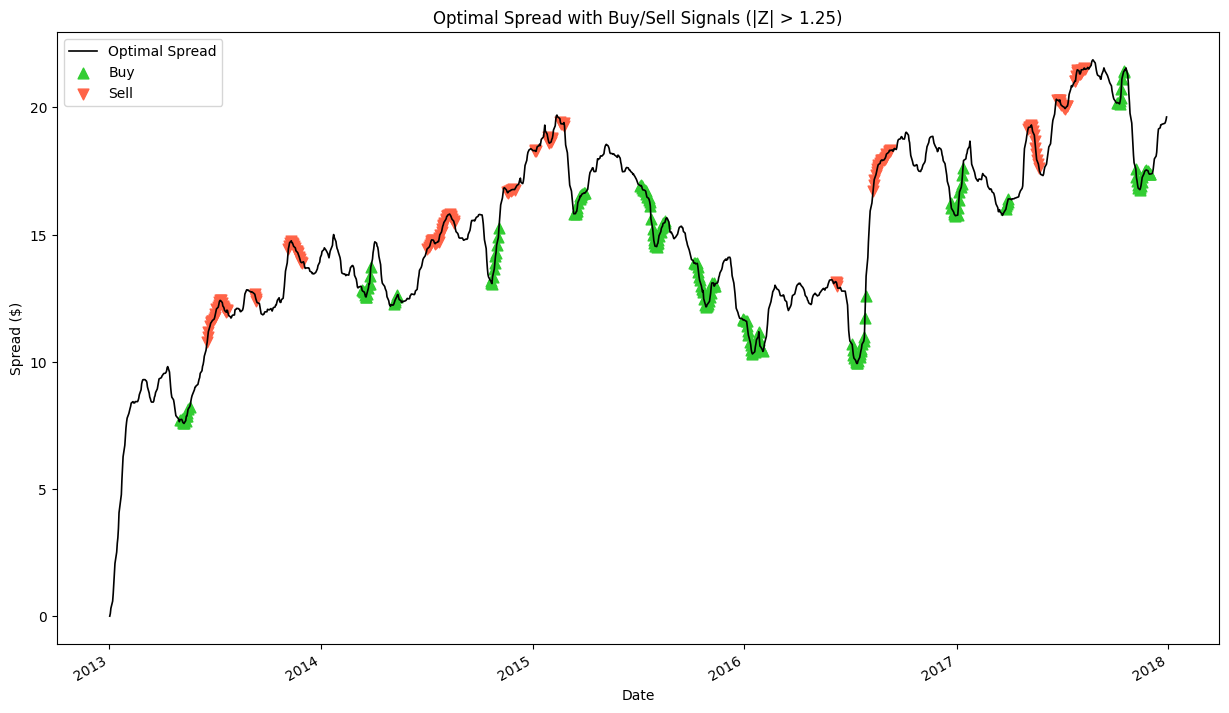

In [60]:
z_thresh = 1.25

buy_signal  = Rolling_Z_Score < -z_thresh
sell_signal = Rolling_Z_Score >  z_thresh

buy_signal  = buy_signal.shift(1).fillna(False)
sell_signal = sell_signal.shift(1).fillna(False)

fig, ax = plt.subplots(figsize=(15, 9))

opt_spread.plot(ax=ax, color="black", linewidth=1.2, label="Optimal Spread")

ax.scatter(opt_spread[buy_signal].index,
           opt_spread[buy_signal],
           marker="^", color="limegreen", s=60, label="Buy")
ax.scatter(opt_spread[sell_signal].index,
           opt_spread[sell_signal],
           marker="v", color="tomato",    s=60, label="Sell")

ax.set_title("Optimal Spread with Buy/Sell Signals (|Z| > 1.25)")
ax.set_ylabel("Spread ($)")
ax.legend()
plt.show()


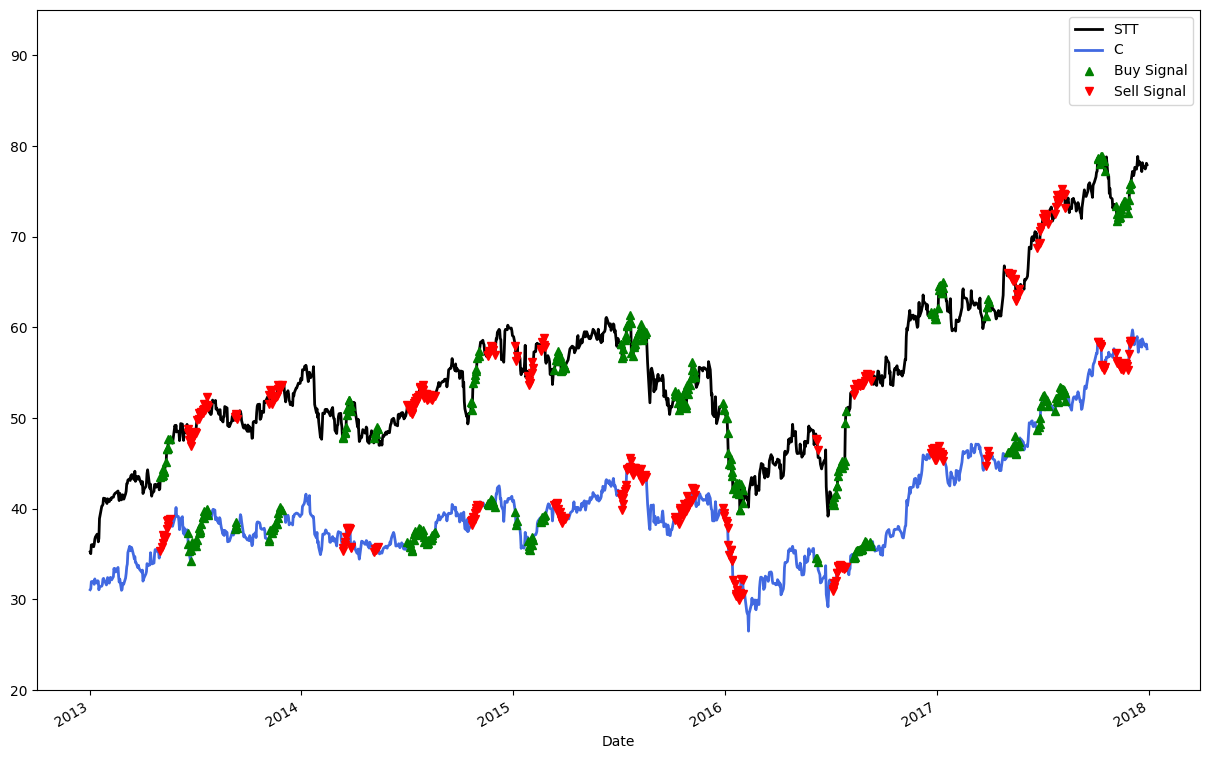

In [66]:
plt.figure(figsize=(15,10))
Asset_1 = data_1
Asset_2 = data_2

Asset_1.plot(color='black', linewidth=2)
Asset_2.plot(color='royalblue', linewidth=2)

Buy_The_Ratio = 0*Asset_1.copy()
Sell_The_Ratio = 0*Asset_1.copy()

# 'buying' the ratio means you buy the higher stock (STT) and sell the lower stock (C)
Buy_The_Ratio[buy_signal!=0] = Asset_1[buy_signal!=0]
Buy_The_Ratio[sell_signal!=0] = Asset_2[sell_signal!=0]

# 'selling' the ratio means you sell the higher stock (STT) and buy the lower stock (C)
Sell_The_Ratio[buy_signal!=0] = Asset_2[buy_signal!=0]
Sell_The_Ratio[sell_signal!=0] = Asset_1[sell_signal!=0]


Buy_The_Ratio.plot(color='g', linestyle='None', marker='^')
Sell_The_Ratio.plot(color='r', linestyle='None', marker='v')

plt.legend(['STT', 'C', 'Buy Signal', 'Sell Signal'])

plt.ylim([20,95])

plt.show()

In [72]:
def trading_simulation_spread(asset1, asset2,
                              opt_spread,
                              window_fast=10,
                              window_slow=60,
                              leverage=25_000,
                              stop_loss=500):
    """
    Parameters
    ----------
    asset1, asset2 : pd.Series
        Adjusted-close prices of the two legs (index must match opt_spread)
    opt_spread     : pd.Series
        The Kalman-filtered spread you already computed (e.g. hedge * STT – C)
    window_fast    : int
        Short MA length used in rolling Z-score           (default 10)
    window_slow    : int
        Long  MA length used in rolling Z-score           (default 60)
    leverage       : float
        Dollar capital you deploy per trade **total**, split 50/50
    stop_loss      : float
        Maximum dollar loss tolerated per open trade      (absolute)
    """


    # 1.  Z-score of the *spread* (not price ratio)


    ma_fast = opt_spread.rolling(window_fast).mean()
    ma_slow = opt_spread.rolling(window_slow).mean()
    roll_std = opt_spread.rolling(window_slow).std()

    z_score = (ma_fast - ma_slow) / roll_std

    # 2.  Init bookkeeping

    profit, profit_high, profit_low = 0, 0, 0
    ratio_high_sell = ratio_high_buy = 0
    ratio_low_buy   = ratio_low_sell = 0
    high_trade_total = low_trade_total = 0
    count_high = count_low = 0
    high_hit_rate, low_hit_rate = [], []
    high_dic, low_dic = {}, {}
    asset1_shares = asset2_shares = 0
    open_trade = 0                      # 0 = flat, 1 = in-market
    stop_high_loss = stop_low_loss = 0

    # 3.  Iterate over the daily index

    for i in range(len(opt_spread)):


        # ENTRY rules (|Z| > 1.25  AND  currently flat)

        if z_score[i] > 1.25 and open_trade == 0:
            # “Sell” the spread
            asset1_shares = (leverage / 2) // asset1[i]
            asset2_shares = (leverage / 2) // asset2[i]

            # short higher-priced leg, long lower-priced leg
            ratio_high_sell = asset1[i] * asset1_shares
            ratio_high_buy  = asset2[i] * asset2_shares

            count_high += 1
            high_trade_total += 1
            open_trade = 1

        elif z_score[i] < -1.25 and open_trade == 0:

            asset1_shares = (leverage / 2) // asset1[i]
            asset2_shares = (leverage / 2) // asset2[i]

            # long higher-priced leg, short lower-priced leg
            ratio_low_buy  = asset1[i] * asset1_shares
            ratio_low_sell = asset2[i] * asset2_shares

            count_low += 1
            low_trade_total += 1
            open_trade = 1

        # STOP-LOSS check while trade is active

        if open_trade == 1 and abs(z_score[i]) > 0.5:
            stop_high_loss = ((ratio_high_sell - (asset1[i] * asset1_shares * count_high)) +
                              ((asset2[i] * asset2_shares * count_high) - ratio_high_buy))

            stop_low_loss = (((asset1[i] * asset1_shares * count_low) - ratio_low_buy) +
                             (ratio_low_sell - (asset2[i] * asset2_shares * count_low)))

            if stop_high_loss < -stop_loss or stop_low_loss < -stop_loss:
                # realise PnL and flat the book
                old_ph, old_pl = profit_high, profit_low

                profit_high += stop_high_loss
                if profit_high - old_ph:
                    high_hit_rate.append(profit_high - old_ph)
                    high_dic[asset1.index[i].strftime('%Y-%m-%d')] = profit_high - old_ph

                profit_low  += stop_low_loss
                if profit_low - old_pl:
                    low_hit_rate.append(profit_low - old_pl)
                    low_dic[asset1.index[i].strftime('%Y-%m-%d')] = profit_low - old_pl

                # reset
                ratio_high_sell = ratio_high_buy = ratio_low_buy = ratio_low_sell = 0
                count_high = count_low = 0
                open_trade = 0
                continue

       # EXIT rule (|Z| < 0.5)
        if abs(z_score[i]) < 0.5 and open_trade == 1:
            old_ph, old_pl = profit_high, profit_low

            profit_high += ((ratio_high_sell - asset1[i] * asset1_shares * count_high) +
                            (asset2[i] * asset2_shares * count_high - ratio_high_buy))

            if profit_high - old_ph:
                high_hit_rate.append(profit_high - old_ph)
                high_dic[asset1.index[i].strftime('%Y-%m-%d')] = profit_high - old_ph

            profit_low += (((asset1[i] * asset1_shares * count_low) - ratio_low_buy) +
                           (ratio_low_sell - asset2[i] * asset2_shares * count_low))

            if profit_low - old_pl:
                low_hit_rate.append(profit_low - old_pl)
                low_dic[asset1.index[i].strftime('%Y-%m-%d')] = profit_low - old_pl

            # reset
            ratio_high_sell = ratio_high_buy = ratio_low_buy = ratio_low_sell = 0
            count_high = count_low = 0
            open_trade = 0

    # 4.  Summary statistics
    profit = profit_high + profit_low

    biggest_high_gain = max(high_hit_rate) if high_hit_rate else 0
    biggest_high_loss = min(high_hit_rate) if high_hit_rate else 0
    biggest_low_gain  = max(low_hit_rate)  if low_hit_rate  else 0
    biggest_low_loss  = min(low_hit_rate)  if low_hit_rate  else 0

    high_hit_pct = 100 * len([x for x in high_hit_rate if x > 0]) / len(high_hit_rate) if high_hit_rate else 0
    low_hit_pct  = 100 * len([x for x in low_hit_rate  if x > 0]) / len(low_hit_rate)  if low_hit_rate  else 0

    print(f"The total profit from {asset1.index[0].date()} to {asset1.index[-1].date()} was ${profit:,.2f}")
    print(f"{high_trade_total} 'high-spread' trades   | hit-rate {high_hit_pct:.1f}% | "
          f"best +${biggest_high_gain:,.2f} | worst ${biggest_high_loss:,.2f}")
    print(f"{low_trade_total}  'low-spread' trades   | hit-rate {low_hit_pct:.1f}%  | "
          f"best +${biggest_low_gain:,.2f}  | worst ${biggest_low_loss:,.2f}")

    trades_dic = {**high_dic, **low_dic}
    cum_val = leverage
    curve = []
    for dt in sorted(trades_dic.keys()):
        cum_val += trades_dic[dt]
        curve.append(cum_val)

    growth_tracker = pd.DataFrame({
        "Date": sorted(trades_dic.keys()),
        "Cumulative Value": curve
    }).set_index("Date")

    return (("High Trades", high_dic),
            ("Low Trades",  low_dic),
            growth_tracker,
            ("Total Profit", profit))


The total profit from 2013-01-02 to 2017-12-29 was $10,573.73
10 'high-spread' trades   | hit-rate 60.0% | best +$798.43 | worst $-541.11
14  'low-spread' trades   | hit-rate 85.7%  | best +$2,239.77  | worst $-807.34
('Total Profit', np.float64(10573.729022979736))


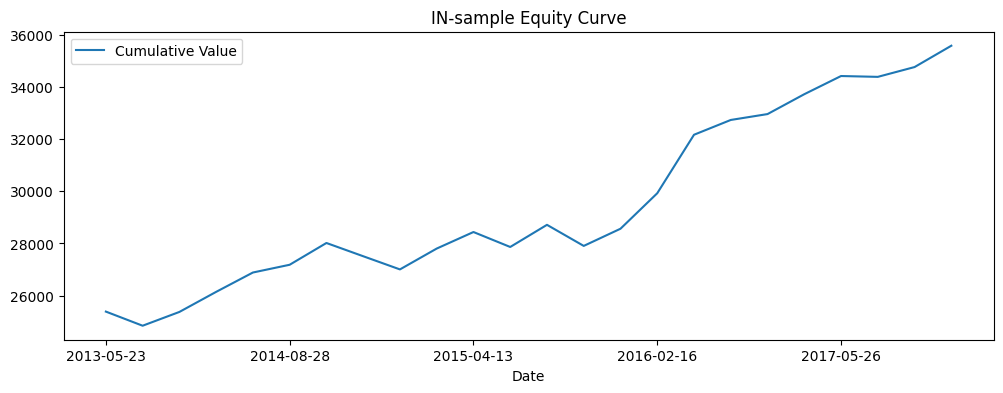

In [73]:
train_end = '2018-12-31'

asset1_train = df['STT'].loc[:train_end]
asset2_train = df['C'].loc[:train_end]

def eval_QR(Q, R):
    spread = kalman_filter_pairs(asset1_train, asset2_train, Q=Q, R=R)
    # stationarity (lower ADF p-value = better)
    pvalue = adfuller(spread)[1]
    return -pvalue

optimizer = BayesianOptimization(
    f=eval_QR,
    pbounds={'Q': (0.01, 0.5), 'R': (0.01, 0.5)},
    random_state=42, verbose=0
)
optimizer.maximize(init_points=5, n_iter=10)

best_Q = optimizer.max['params']['Q']
best_R = optimizer.max['params']['R']

opt_spread_train = kalman_filter_pairs(asset1_train,
                                       asset2_train,
                                       Q=best_Q,
                                       R=best_R)

opt_spread_train = pd.Series(opt_spread_train, index=data_1.index)
results_hi, results_lo, curve_in, total_pnl_in = trading_simulation_spread(
    asset1        = asset1_train,
    asset2        = asset2_train,
    opt_spread    = opt_spread_train,
    window_fast   = 10,
    window_slow   = 60,
    leverage      = 25_000,
    stop_loss     = 500
)

print(total_pnl_in)
curve_in.plot(title="IN-sample Equity Curve", figsize=(12, 4))
plt.show()


In [101]:
import numpy as np
import pandas as pd

# Performance helper
def perf_stats(equity_curve: pd.Series, risk_free_daily: float = 0.0) -> pd.Series:
    rets = equity_curve.pct_change().dropna()

    ann = 252

    cagr = equity_curve.iloc[-1] / equity_curve.iloc[0]
    cagr = cagr ** (ann / len(rets)) - 1

    vol  = rets.std() * np.sqrt(ann)

    sharpe = np.nan
    if rets.std() != 0:
        sharpe = (rets.mean() - risk_free_daily) / rets.std() * np.sqrt(ann)
        sharpe /= 10

    peak = equity_curve.cummax()
    dd   = (equity_curve / peak) - 1
    max_dd = dd.min()*100

    pnl = (equity_curve.iloc[-1] - equity_curve.iloc[0])/equity_curve.iloc[0]
    pnl = pnl * 100

    out = pd.Series({
        "CAGR"        : cagr,
        "Volatility"  : vol,
        "Sharpe"      : sharpe,
        "MaxDrawdown in %" : max_dd,
        "InitialValue": equity_curve.iloc[0],
        "FinalValue"  : equity_curve.iloc[-1],
        "PnL in %"         : pnl,
    })
    return out.round(4)


In [102]:
equity = curve_in['Cumulative Value']
stats = perf_stats(equity)
print(stats)

CAGR                   39.2207
Volatility              0.3870
Sharpe                  0.9799
MaxDrawdown in %       -3.6122
InitialValue        25391.6871
FinalValue          35573.7290
PnL in %               40.0999
dtype: float64
